## Codigo & Explicación Final 
### Tipo de Red Neuronal Desarrollada:
##### - RNN LSTM Multivariate Time Series


In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat, read_csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM
from keras.models import  Sequential
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

Antes de que se pueda utilizar el aprendizaje automático para prediccion de valores, los problemas de pronóstico de series de tiempo deben reformularse como problemas de aprendizaje supervisados. Desde una secuencia hasta pares de secuencias de entrada y salida.

In [35]:
# Convertir Serie de Tiempo en Dataset Supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Secuencia Input (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Secuencia Forecast-Prediccion (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Secuencias Juntas
    agg = concat(cols, axis=1)
    agg.columns = names
    # Eliminar outlayers NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def graficaUnitaria(fix:16,fiy:8,historyXYZ,strEvaluacion,mostrar,nombreArchivo):
    figure(figsize=(fix,fiy))
    pyplot.grid(True)
    if(strEvaluacion=='accuracy'):
        pyplot.title("ACCURACY vs VAL_ACCURACY")
        pyplot.plot(historyXYZ.history['acc'], label='Train ACC')
        pyplot.legend()
        pyplot.plot(historyXYZ.history['val_acc'], label='Test VAL_aCC')
        pyplot.legend()
        pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
    else:
        pyplot.title("LOSS vs VAL_LOSS")
        pyplot.plot(historyXYZ.history['loss'], label='Train LOSS')
        pyplot.plot(historyXYZ.history['val_loss'], label='Test VAL_LOSS')
        pyplot.legend()
        pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
    

#### Preprocesamiento de Datos
Lectura, Normalizacion & Conversion a un Dataframe de Aprendizaje Supervisado

In [36]:
dataset = read_csv('aucorpTrain.csv', header=0, index_col=0)
dataset=dataset.iloc[:,2:]
values = dataset.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# Cast a un solo tipo de dato
values = values.astype('float32')
# Normalizacion
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Datos a Modelo Aprendizaje Supervisado
reframed = series_to_supervised(scaled, 1, 1)
#Datos para entrenar
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

### Caso 1
1000 epochs, 1 Capa LSTM(12), Dense(1), Optimizador Adam , Batch = 40 , Funcion Activacion = Sigmoide

In [37]:
# Train and Test Data
values = reframed.values
train = values[:68, :]
test = values[69:, :]
# Separacion Datos Input-Output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# Reshape input para tener 3D [muestra, timesteps, caracteristicas]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [38]:
# RED NEURONAL
modelC1 = Sequential()
modelC1.add(LSTM(12, dropout=0.0002, input_shape=(train_X.shape[1], train_X.shape[2])))
modelC1.add(Dense(1, activation='sigmoid'))
sgd = optimizers.SGD(lr=0.0002, decay=1e-7, momentum=0.9, nesterov=True)
modelC1.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
historyC1 = modelC1.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=False)
modelC1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 12)                1392      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 13        
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________


#### Evaluacion Resultados


Populating the interactive namespace from numpy and matplotlib


C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


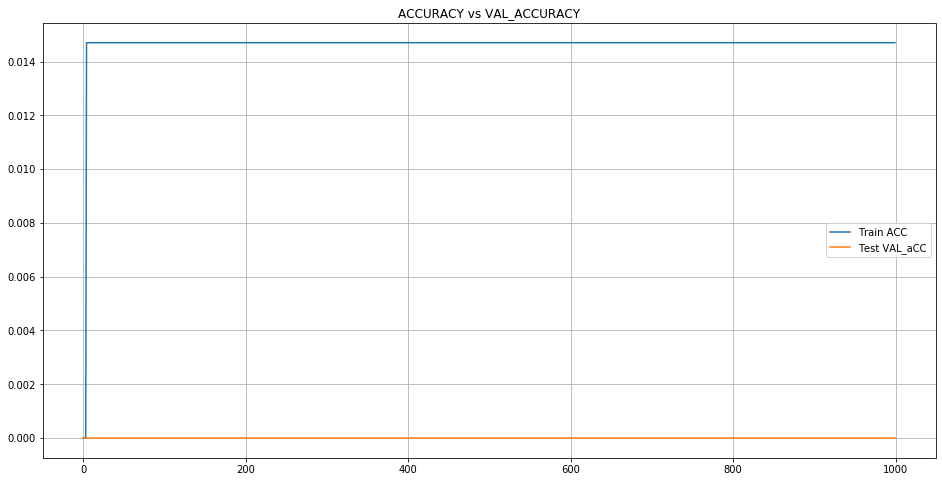

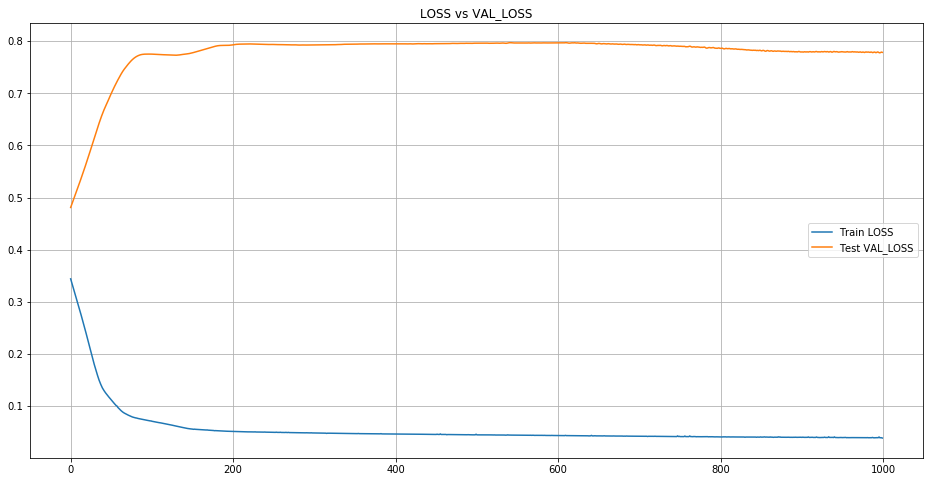

In [39]:
%pylab inline
graficaUnitaria(16,8,historyC1,'accuracy',True,'c1Acc.svg')
graficaUnitaria(16,8,historyC1,'loss',True,'c1Loss.svg')

### Caso 2
1000 epochs, 3 Capa LSTM (12,12,12,1), Dense, Learning Rate = 0.0002, Decay = 1e-7, Funcion Activacion Sigmoide

In [40]:
# RED NEURONAL
modelC2 = Sequential()
modelC2.add(LSTM(12, dropout=0.0002, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
modelC2.add(LSTM(12, dropout=0.0002, return_sequences=True))
modelC2.add(LSTM(12, dropout=0.0002))
modelC2.add(Dense(1, activation='sigmoid'))
modelC2.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
# Fitting
historyC2 = modelC2.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=True)
modelC2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1, 12)             1392      
_________________________________________________________________
lstm_27 (LSTM)               (None, 1, 12)             1200      
_________________________________________________________________
lstm_28 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 13        
Total params: 3,805
Trainable params: 3,805
Non-trainable params: 0
_________________________________________________________________


#### Evaluacion de Resultados

Populating the interactive namespace from numpy and matplotlib


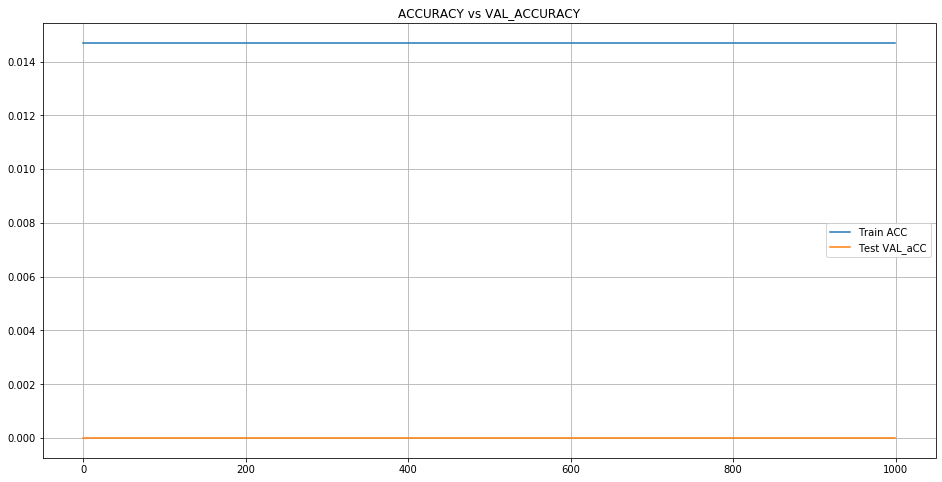

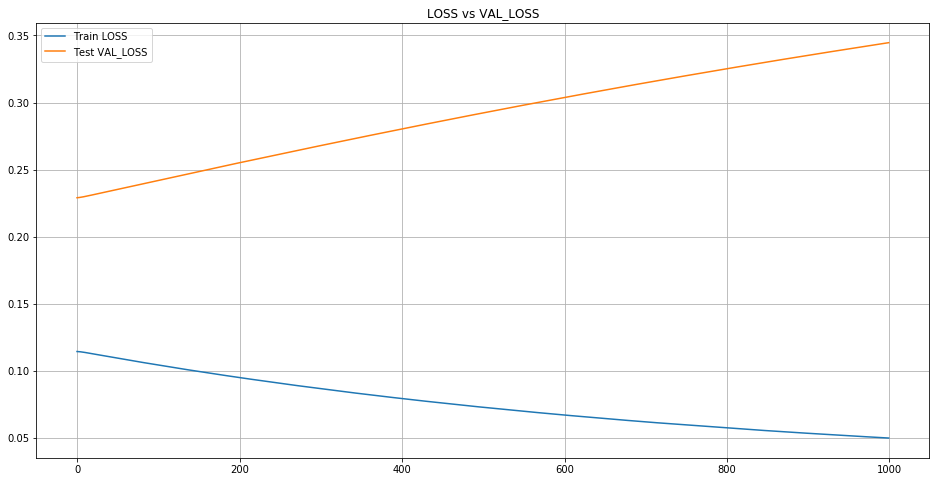

In [41]:
%pylab inline
graficaUnitaria(16,8,historyC2,'accuracy',True,'c2Acc.svg')
graficaUnitaria(16,8,historyC2,'loss',True,'c2Loss.svg')

### Caso 3
1000 epochs, 4 Capa LSTM (50,40,30,20), Dense (1), Learning Rate = 0.0002, Funcion Activacion = Sigmoide, Batch=40

In [42]:
# RED NEURONAL
modelC3 = Sequential()
modelC3.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
modelC3.add(LSTM(40, return_sequences=True))
modelC3.add(LSTM(30, return_sequences=True))
modelC3.add(LSTM(20))
modelC3.add(Dense(1, activation='sigmoid'))
modelC3.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
historyC3 = modelC3.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=False)
modelC3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 1, 50)             13400     
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 40)             14560     
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 30)             8520      
_________________________________________________________________
lstm_32 (LSTM)               (None, 20)                4080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 40,581
Trainable params: 40,581
Non-trainable params: 0
_________________________________________________________________


#### Evaluacion de Resultados

Populating the interactive namespace from numpy and matplotlib


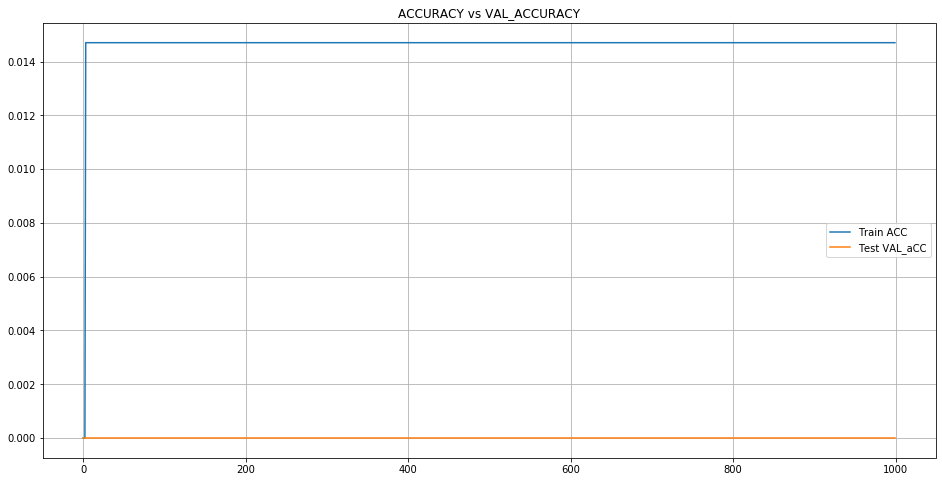

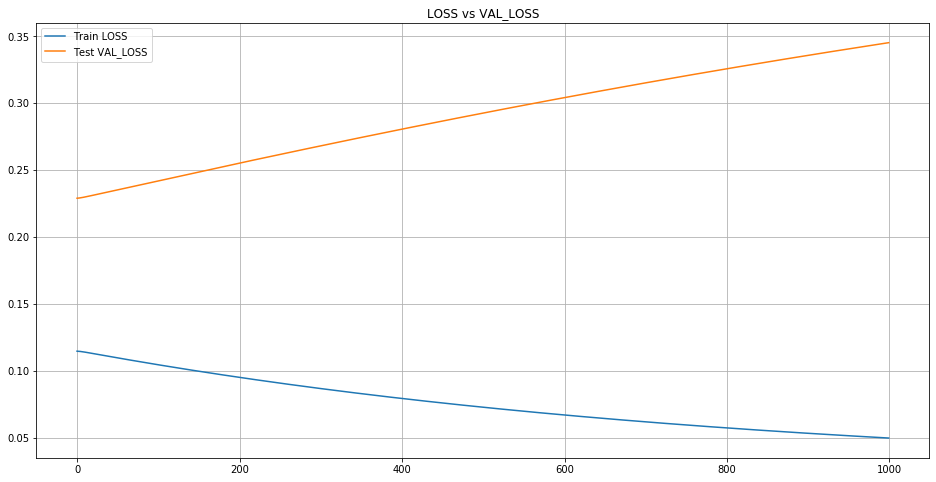

In [43]:
%pylab inline
graficaUnitaria(16,8,historyC3,'accuracy',True,'c3Acc.svg')
graficaUnitaria(16,8,historyC3,'loss',True,'c3Loss.svg')

### Caso 4
1000 epochs, 4 Capa LSTM (50,40,30,20), Dense(1), Optimizador LR = 0.0002, Funcion Activacion = Sigmoide, Batch=40

In [44]:
# RED NEURONAL
modelC4 = Sequential()
modelC4.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
modelC4.add(LSTM(40, return_sequences=True))
modelC4.add(LSTM(30, return_sequences=True))
modelC4.add(LSTM(20))
modelC4.add(Dense(1, activation='sigmoid'))
modelC4.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
historyC4 = modelC4.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=True)
modelC4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 1, 50)             13400     
_________________________________________________________________
lstm_34 (LSTM)               (None, 1, 40)             14560     
_________________________________________________________________
lstm_35 (LSTM)               (None, 1, 30)             8520      
_________________________________________________________________
lstm_36 (LSTM)               (None, 20)                4080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 40,581
Trainable params: 40,581
Non-trainable params: 0
_________________________________________________________________


### Evaluacion de Resultados

Populating the interactive namespace from numpy and matplotlib


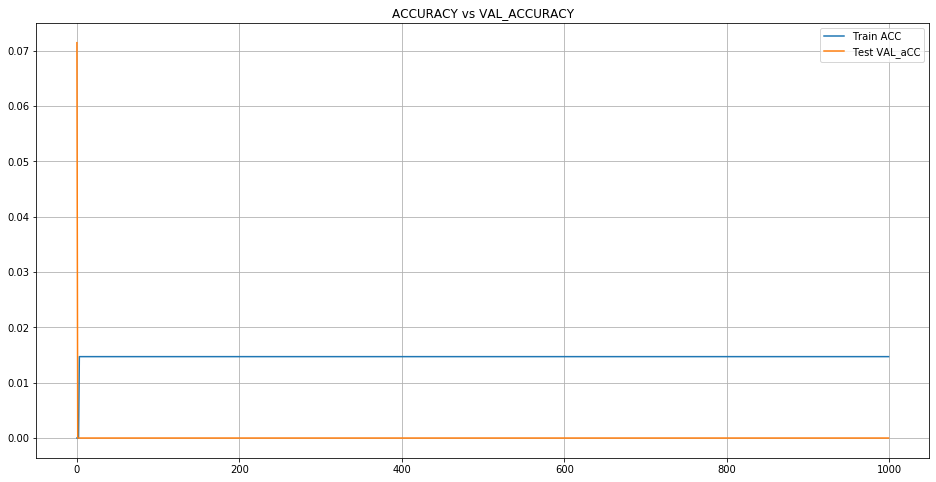

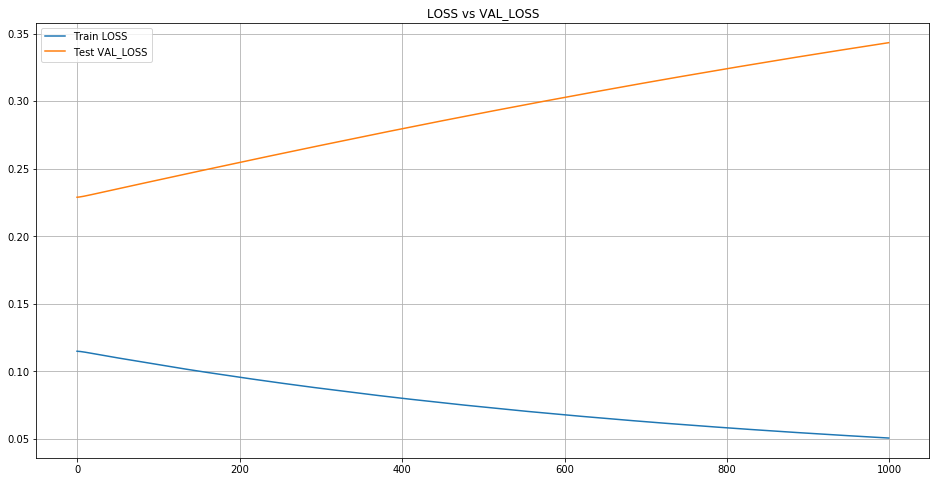

In [45]:
%pylab inline
graficaUnitaria(16,8,historyC4,'accuracy',True,'c4Acc.svg')
graficaUnitaria(16,8,historyC4,'loss',True,'c4Loss.svg')

##### Objetos Resultantes
- modelC1
- modelC2
- modelC3
- modelC4
- historyC1
- historyC2
- historyC3
- historyC4



In [ ]:
# Prediccion
ypredictC1 = modelC1.predict(test_X)
ypredictC2 = modelC2.predict(test_X)
ypredictC3 = modelC3.predict(test_X)
ypredictC4 = modelC4.predict(test_X)

In [ ]:
ypredictC1

In [ ]:
ypredictC2

In [ ]:
ypredictC3

In [ ]:
ypredictC4

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Inversion de Escala MinMax
inv_yhat = concatenate((ypredict, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Inversion de Escala Actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculo de RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)